/tmp/ipython-input-1054086008.py:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['cloudCover'] = df['cloudCover'].fillna(method='ffill').fillna(method='bfill')


Sınıflandırma Eşiği (Medyan): 0.5623 kW

Modeller Eğitiliyor ve Karşılaştırılıyor...
--------------------------------------------------
Random Forest Başarısı (Accuracy): %75.87
Logistic Regression Başarısı (Accuracy): %59.61
KNN (k=5) Başarısı (Accuracy): %81.38

--------------------------------------------------
EN BAŞARILI MODEL: KNN (k=5)
--------------------------------------------------


/tmp/ipython-input-1054086008.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')


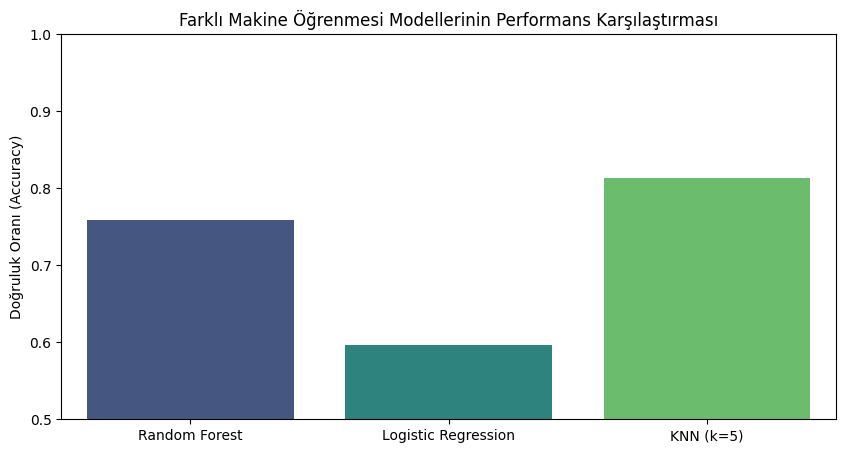

KNN için özellik önemi hesaplanıyor (Örneklem üzerinden hızlı işlem)...


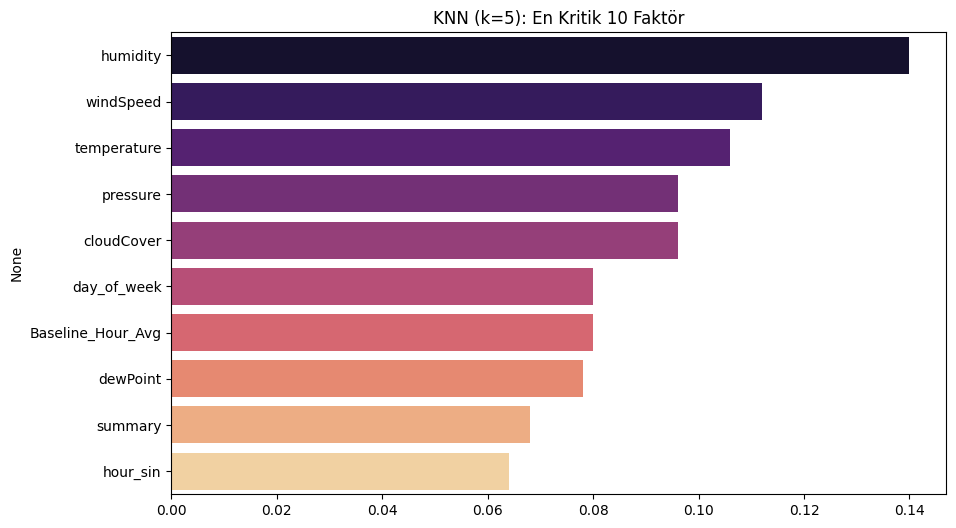

<Figure size 800x600 with 0 Axes>

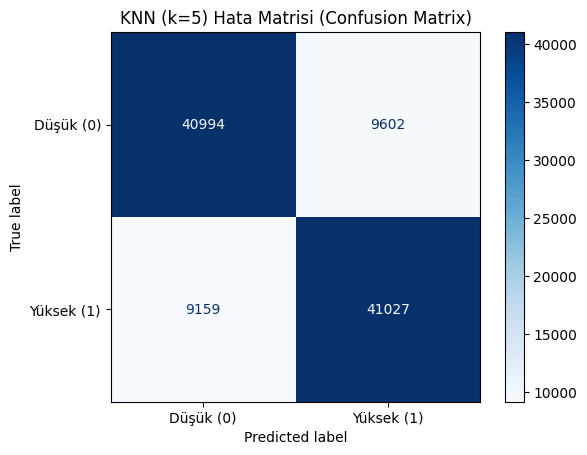


Analiz tamamlandı. Grafikler başarıyla oluşturuldu.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Problem tanımı: Ev enerji tüketiminin yüksek mi düşük mü olacağını tahmin etmek.
# İlk olarak datayı yükleyelim.
df = pd.read_csv("SmartHomeDataset.csv", low_memory=False)

# Ham datamızda 'time' sütunumuz "Unix Timestamp" yani 1 ocak 1970 den bu zamana geçen sürenin saniyesi formatındadır. Bu değer model için anlamsız olacağı için insanların ve modelin anlayabileceği 'Datetime' formatına cevirmeliyiz.
df['time'] = pd.to_numeric(df['time'], errors='coerce')
df = df.dropna(subset=['time'])
df['time'] = pd.to_datetime(df['time'], unit='s')

# Hava durumu verilerindeki string değerlerin hepsini sayıya dönüştürüyoruz.
weather_cols = ['temperature', 'humidity', 'visibility', 'windSpeed',
                'pressure', 'cloudCover', 'windBearing', 'dewPoint', 'precipProbability']

for col in weather_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
""
# Eksik verileri NaN ile doldurduk. Hava durumu verileri anlık olarak radikal şekilde değişmeyeceği için bir önceki saatin havasına göre benzer olması muhtemel olduğu için bir önceki saate göre doldurulmuştur.
df['cloudCover'] = df['cloudCover'].fillna(method='ffill').fillna(method='bfill')
df = df.dropna() # Doldurulamayan verileri veri setinden çıkarıyoyurz.

# Encoding işlemi - 'sumary' sütunundaki "Clear" ve "Cloudy" verileri LabelEncoder ile sayısal değerlere döndürüyoruz("Clear" : 0, "Coludy": 1 gibi).
le = LabelEncoder()
df['summary'] = le.fit_transform(df['summary'].astype(str))

# Modelin daha iyi sonuclar vermesi için Hangi ay olduğu, hafta içimi hafta sonu mu olduğu, günün hangi saati olduğu modele verilecektir.
df['month'] = df['time'].dt.month
df['day_of_week'] = df['time'].dt.dayofweek
df['hour'] = df['time'].dt.hour

# Sinüs ve cosinüs dönüşümleri yaparak saat 23:00 ile 00:00 arasındaki farkı 1'e indiriyoruz. Normalde model için aradaki fark 23 saattir.
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

# Hedeff değişken olarak 'use [kW]' sutünü alınacaktır. Bu sütunun ortalaması alınıp ortalamasından aşağısı 0 yani düşük tüketim, yukarısı 1 yani yüksek tüketim olucak şekilde ayarlanmıştır.
limit = df['use [kW]'].median()
df['Energy_Class'] = (df['use [kW]'] > limit).astype(int)
print(f"Sınıflandırma Eşiği (Medyan): {limit:.4f} kW")

# Amacımız dış faktörlere bakarak kullanılabilecek tüketimin yüksek mi düşük mü olacağını tahmin etmek olduğu için evin içindeki cihazların tükettiği elektriği modelin kopya çekmemesi için data olarak alımyoruz.
drop_sensors = [
    'time', 'gen [kW]', 'House overall [kW]',
    'Dishwasher [kW]', 'Furnace 1 [kW]', 'Furnace 2 [kW]', 'Home office [kW]',
    'Fridge [kW]', 'Wine cellar [kW]', 'Garage door [kW]', 'Kitchen 12 [kW]',
    'Kitchen 14 [kW]', 'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]',
    'Microwave [kW]', 'Living room [kW]', 'Solar [kW]',
    'icon', 'apparentTemperature',
    'Energy_Class'
]

# Features(x) ve Target(y) belirleme
X = df.drop(columns=drop_sensors, errors='ignore')
y = df['Energy_Class']

# Veri setini 80 eğitim, 20 test olucak şekilde ayırdık.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pivot İşlemleri
# ADIM 1: Ortalamaları eğitim setinden öğreniyoruz.
pivot_hour_mean = X_train.groupby('hour')['use [kW]'].mean().to_dict()
pivot_weather_mean = X_train.groupby('summary')['use [kW]'].mean().to_dict()
global_mean = X_train['use [kW]'].mean() # Sözlükte olmayan değer gelirse diye genel ortalama

# ADIM 2: Öğrendiğimiz bu değerleri yeni bir sütun olarak ekliyoruz.
#X_train'e ekleme
X_train['Baseline_Hour_Avg'] = X_train['hour'].map(pivot_hour_mean).fillna(global_mean)
X_train['Baseline_Weather_Avg'] = X_train['summary'].map(pivot_weather_mean).fillna(global_mean)

# X_test'e ekleme
X_test['Baseline_Hour_Avg'] = X_test['hour'].map(pivot_hour_mean).fillna(global_mean)
X_test['Baseline_Weather_Avg'] = X_test['summary'].map(pivot_weather_mean).fillna(global_mean)

# ADIM 3: Artık 'use [kW]' ile işimiz bitti. Model kopya çekmesin diye siliyoruz.
X_train = X_train.drop(columns=['use [kW]'])
X_test = X_test.drop(columns=['use [kW]'])

# StandartScaler: Sıcaklık sütunundaki 20 derece ile Basınç sütunundaki 1000 mbar arasındaki değerlerin farkı modelleri yanıltacağı StandartScaler kullanılmıştır.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model olarak Random Forest, Logistic Regression, KNN modelleri denenmiştir. Random forest düz kullanılmış ve overfit olduğu gözlemlenmiştir bu yüzden derinliği kısıtlanmıştır.
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Başarısı (Accuracy): %{acc*100:.2f}")

# En iyi modeli belirleyelim.
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

#Model Karşılaştırma
plt.figure(figsize=(10, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')
plt.title('Farklı Makine Öğrenmesi Modellerinin Performans Karşılaştırması')
plt.ylabel('Doğruluk Oranı (Accuracy)')
plt.ylim(0.5, 1.0)
plt.show()

#Feature Importance
plt.figure(figsize=(10, 6))

if best_model_name == "Random Forest":
    feature_imp = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(10)
else:
    from sklearn.inspection import permutation_importance
    X_sample = X_test_scaled[:100]
    y_sample = y_test[:100]

    perm_result = permutation_importance(best_model, X_sample, y_sample, n_repeats=5, random_state=42)
    feature_imp = pd.Series(perm_result.importances_mean, index=X_train.columns).sort_values(ascending=False).head(10)

sns.barplot(x=feature_imp.values, y=feature_imp.index, hue=feature_imp.index, palette='magma', legend=False)
plt.title(f'{best_model_name}: En Kritik 10 Faktör')
plt.show()

#Confusion Matrix
plt.figure(figsize=(8, 6))
y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Düşük (0)', 'Yüksek (1)'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f'{best_model_name} Hata Matrisi (Confusion Matrix)')
plt.show()

print("\nAnaliz tamamlandı. Grafikler başarıyla oluşturuldu.")




In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/FinalÖdevi

/content/drive/MyDrive/FinalÖdevi


Bu kodu çalıştırdıktan sonra, Drive'ınızdaki dosyalara `/content/drive/MyDrive` yolu üzerinden erişebilirsiniz.